In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import xgboost as xgb
print("xgb.__version__:", xgb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

xgb.__version__: 2.1.1


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [3]:
# input parameters
fs_type = 'fsv24'
train_type = "small"

In [4]:
# Parameters
fs_type = "full"


In [5]:
# Load the feature selection results
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 0
Categorical features: 0
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  18


number of constant cols:  198


Numerical Columns: 660
Categorical Columns: 10


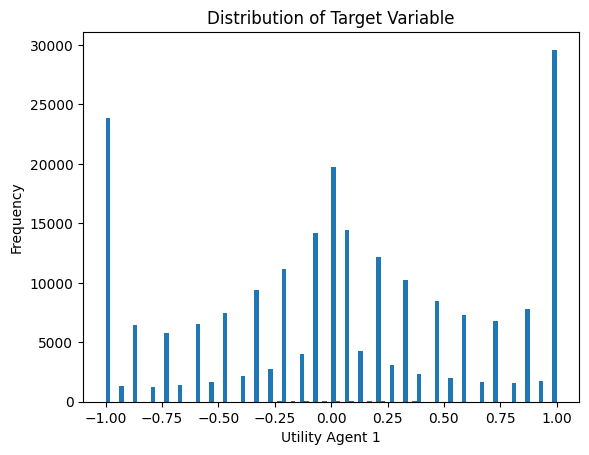

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model


In [9]:
if train_type == "small":
    LEARNING_RATE = 0.03
    NUM_BOOST_ROUND = 2500
elif train_type == "medium":
    LEARNING_RATE = 0.01
    NUM_BOOST_ROUND = 5000
elif train_type == "large":
    LEARNING_RATE = 0.005
    NUM_BOOST_ROUND = 10_000
elif train_type == "xlarge":
    LEARNING_RATE = 0.001
    NUM_BOOST_ROUND = 20_000


print(LEARNING_RATE, NUM_BOOST_ROUND)

0.03 2500


In [10]:
def train_models(
        df_train,
        target,
        numerical_cols,
        categorical_cols,
        split_list=None
    ):
    # Define the parameters
    params = {
        'objective': "reg:squarederror",
        'eval_metric': 'rmse',
        'max_depth': 8,
        'max_bin': 128,
        'learning_rate': LEARNING_RATE,
        'alpha': 0.1,
        'colsample_bytree': 0.5,
        'subsample': 0.8,
        'min_child_weight': 10,
        'seed': 2112,
        'verbosity': 0,
    }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]

        feature_types = [
            "c" if col in categorical_cols else "q" 
            for col in numerical_cols + categorical_cols
        ]
        
        # Convert to DMatrix format
        train_data = xgb.DMatrix(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            feature_types=feature_types,
            enable_categorical=True,
            feature_names=numerical_cols + categorical_cols
        )
        val_data = xgb.DMatrix(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            feature_types=feature_types,
            enable_categorical=True,
            feature_names=numerical_cols + categorical_cols
        )

        # Train the model
        model = xgb.train(
            params,
            train_data,
            num_boost_round=NUM_BOOST_ROUND,
            evals=[(val_data, 'val')],
            verbose_eval=100,
        )
        
        # Get feature importance
        importance_dict = model.get_score(importance_type='gain')
        feat_importance = pd.DataFrame(
            {'feature': list(importance_dict.keys()),
             f'importance_f{fold}': list(importance_dict.values())}
        )
        feat_importance_dfs.append(feat_importance)
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(val_data)

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold

        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv1.parquet', index=False)

Fold 1


[0]	val-rmse:0.55206


[100]	val-rmse:0.47260


[200]	val-rmse:0.45512


[300]	val-rmse:0.44739


[400]	val-rmse:0.44152


[500]	val-rmse:0.43801


[600]	val-rmse:0.43572


[700]	val-rmse:0.43423


[800]	val-rmse:0.43312


[900]	val-rmse:0.43250


[1000]	val-rmse:0.43206


[1100]	val-rmse:0.43161


[1200]	val-rmse:0.43118


[1300]	val-rmse:0.43080


[1400]	val-rmse:0.43056


[1500]	val-rmse:0.43045


[1600]	val-rmse:0.43024


[1700]	val-rmse:0.42996


[1800]	val-rmse:0.42995


[1900]	val-rmse:0.42981


[2000]	val-rmse:0.42972


[2100]	val-rmse:0.42962


[2200]	val-rmse:0.42964


[2300]	val-rmse:0.42952


[2400]	val-rmse:0.42952


[2499]	val-rmse:0.42957


Fold 1 - RMSE: 0.42927006013875824
Fold 2


[0]	val-rmse:0.58641


[100]	val-rmse:0.49074


[200]	val-rmse:0.47768


[300]	val-rmse:0.47142


[400]	val-rmse:0.46751


[500]	val-rmse:0.46461


[600]	val-rmse:0.46254


[700]	val-rmse:0.46164


[800]	val-rmse:0.46072


[900]	val-rmse:0.45995


[1000]	val-rmse:0.45933


[1100]	val-rmse:0.45883


[1200]	val-rmse:0.45825


[1300]	val-rmse:0.45794


[1400]	val-rmse:0.45765


[1500]	val-rmse:0.45746


[1600]	val-rmse:0.45737


[1700]	val-rmse:0.45724


[1800]	val-rmse:0.45716


[1900]	val-rmse:0.45701


[2000]	val-rmse:0.45697


[2100]	val-rmse:0.45689


[2200]	val-rmse:0.45674


[2300]	val-rmse:0.45664


[2400]	val-rmse:0.45665


[2499]	val-rmse:0.45657


Fold 2 - RMSE: 0.4560266367182996
Fold 3


[0]	val-rmse:0.60382


[100]	val-rmse:0.48747


[200]	val-rmse:0.46892


[300]	val-rmse:0.46235


[400]	val-rmse:0.45859


[500]	val-rmse:0.45544


[600]	val-rmse:0.45340


[700]	val-rmse:0.45197


[800]	val-rmse:0.45133


[900]	val-rmse:0.45071


[1000]	val-rmse:0.45049


[1100]	val-rmse:0.45020


[1200]	val-rmse:0.44969


[1300]	val-rmse:0.44960


[1400]	val-rmse:0.44947


[1500]	val-rmse:0.44925


[1600]	val-rmse:0.44918


[1700]	val-rmse:0.44893


[1800]	val-rmse:0.44887


[1900]	val-rmse:0.44891


[2000]	val-rmse:0.44883


[2100]	val-rmse:0.44867


[2200]	val-rmse:0.44864


[2300]	val-rmse:0.44845


[2400]	val-rmse:0.44843


[2499]	val-rmse:0.44845


Fold 3 - RMSE: 0.448017972408727
Fold 4


[0]	val-rmse:0.59488


[100]	val-rmse:0.48776


[200]	val-rmse:0.46703


[300]	val-rmse:0.45887


[400]	val-rmse:0.45399


[500]	val-rmse:0.45044


[600]	val-rmse:0.44836


[700]	val-rmse:0.44710


[800]	val-rmse:0.44605


[900]	val-rmse:0.44539


[1000]	val-rmse:0.44490


[1100]	val-rmse:0.44438


[1200]	val-rmse:0.44386


[1300]	val-rmse:0.44336


[1400]	val-rmse:0.44294


[1500]	val-rmse:0.44280


[1600]	val-rmse:0.44270


[1700]	val-rmse:0.44245


[1800]	val-rmse:0.44222


[1900]	val-rmse:0.44209


[2000]	val-rmse:0.44193


[2100]	val-rmse:0.44181


[2200]	val-rmse:0.44162


[2300]	val-rmse:0.44148


[2400]	val-rmse:0.44149


[2499]	val-rmse:0.44137


Fold 4 - RMSE: 0.44099287844091484
Fold 5


[0]	val-rmse:0.54703


[100]	val-rmse:0.45869


[200]	val-rmse:0.43746


[300]	val-rmse:0.42813


[400]	val-rmse:0.42195


[500]	val-rmse:0.41786


[600]	val-rmse:0.41580


[700]	val-rmse:0.41429


[800]	val-rmse:0.41274


[900]	val-rmse:0.41175


[1000]	val-rmse:0.41114


[1100]	val-rmse:0.41052


[1200]	val-rmse:0.41002


[1300]	val-rmse:0.40965


[1400]	val-rmse:0.40931


[1500]	val-rmse:0.40915


[1600]	val-rmse:0.40900


[1700]	val-rmse:0.40902


[1800]	val-rmse:0.40897


[1900]	val-rmse:0.40889


[2000]	val-rmse:0.40888


[2100]	val-rmse:0.40886


[2200]	val-rmse:0.40889


[2300]	val-rmse:0.40883


[2400]	val-rmse:0.40876


[2499]	val-rmse:0.40870


Fold 5 - RMSE: 0.40841631563825065
List of oof scores: [0.42927006013875824, 0.4560266367182996, 0.448017972408727, 0.44099287844091484, 0.40841631563825065]
Average oof score: 0.43654477266899006


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv2.parquet', index=False)

Fold 1


[0]	val-rmse:0.53433


[100]	val-rmse:0.45255


[200]	val-rmse:0.43572


[300]	val-rmse:0.43000


[400]	val-rmse:0.42533


[500]	val-rmse:0.42214


[600]	val-rmse:0.42002


[700]	val-rmse:0.41817


[800]	val-rmse:0.41708


[900]	val-rmse:0.41591


[1000]	val-rmse:0.41530


[1100]	val-rmse:0.41497


[1200]	val-rmse:0.41446


[1300]	val-rmse:0.41422


[1400]	val-rmse:0.41397


[1500]	val-rmse:0.41374


[1600]	val-rmse:0.41360


[1700]	val-rmse:0.41324


[1800]	val-rmse:0.41311


[1900]	val-rmse:0.41296


[2000]	val-rmse:0.41288


[2100]	val-rmse:0.41281


[2200]	val-rmse:0.41268


[2300]	val-rmse:0.41256


[2400]	val-rmse:0.41247


[2499]	val-rmse:0.41250


Fold 1 - RMSE: 0.4122669473047089
Fold 2


[0]	val-rmse:0.54306


[100]	val-rmse:0.43896


[200]	val-rmse:0.42228


[300]	val-rmse:0.41634


[400]	val-rmse:0.41268


[500]	val-rmse:0.41114


[600]	val-rmse:0.41014


[700]	val-rmse:0.40969


[800]	val-rmse:0.40899


[900]	val-rmse:0.40871


[1000]	val-rmse:0.40829


[1100]	val-rmse:0.40820


[1200]	val-rmse:0.40788


[1300]	val-rmse:0.40791


[1400]	val-rmse:0.40801


[1500]	val-rmse:0.40802


[1600]	val-rmse:0.40808


[1700]	val-rmse:0.40811


[1800]	val-rmse:0.40800


[1900]	val-rmse:0.40800


[2000]	val-rmse:0.40809


[2100]	val-rmse:0.40807


[2200]	val-rmse:0.40810


[2300]	val-rmse:0.40809


[2400]	val-rmse:0.40813


[2499]	val-rmse:0.40803


Fold 2 - RMSE: 0.40756674561070033
Fold 3


[0]	val-rmse:0.61078


[100]	val-rmse:0.49110


[200]	val-rmse:0.46825


[300]	val-rmse:0.46019


[400]	val-rmse:0.45423


[500]	val-rmse:0.45004


[600]	val-rmse:0.44751


[700]	val-rmse:0.44564


[800]	val-rmse:0.44433


[900]	val-rmse:0.44299


[1000]	val-rmse:0.44196


[1100]	val-rmse:0.44143


[1200]	val-rmse:0.44068


[1300]	val-rmse:0.44026


[1400]	val-rmse:0.43962


[1500]	val-rmse:0.43931


[1600]	val-rmse:0.43887


[1700]	val-rmse:0.43846


[1800]	val-rmse:0.43834


[1900]	val-rmse:0.43809


[2000]	val-rmse:0.43791


[2100]	val-rmse:0.43774


[2200]	val-rmse:0.43762


[2300]	val-rmse:0.43743


[2400]	val-rmse:0.43734


[2499]	val-rmse:0.43732


Fold 3 - RMSE: 0.43699308303871215
Fold 4


[0]	val-rmse:0.60414


[100]	val-rmse:0.49326


[200]	val-rmse:0.47006


[300]	val-rmse:0.46191


[400]	val-rmse:0.45634


[500]	val-rmse:0.45265


[600]	val-rmse:0.45060


[700]	val-rmse:0.44906


[800]	val-rmse:0.44776


[900]	val-rmse:0.44703


[1000]	val-rmse:0.44630


[1100]	val-rmse:0.44572


[1200]	val-rmse:0.44527


[1300]	val-rmse:0.44487


[1400]	val-rmse:0.44472


[1500]	val-rmse:0.44444


[1600]	val-rmse:0.44409


[1700]	val-rmse:0.44373


[1800]	val-rmse:0.44363


[1900]	val-rmse:0.44347


[2000]	val-rmse:0.44331


[2100]	val-rmse:0.44327


[2200]	val-rmse:0.44319


[2300]	val-rmse:0.44297


[2400]	val-rmse:0.44284


[2499]	val-rmse:0.44277


Fold 4 - RMSE: 0.44248413889728183
Fold 5


[0]	val-rmse:0.58835


[100]	val-rmse:0.48761


[200]	val-rmse:0.46496


[300]	val-rmse:0.45579


[400]	val-rmse:0.44982


[500]	val-rmse:0.44641


[600]	val-rmse:0.44439


[700]	val-rmse:0.44297


[800]	val-rmse:0.44193


[900]	val-rmse:0.44092


[1000]	val-rmse:0.44017


[1100]	val-rmse:0.43942


[1200]	val-rmse:0.43902


[1300]	val-rmse:0.43867


[1400]	val-rmse:0.43847


[1500]	val-rmse:0.43819


[1600]	val-rmse:0.43817


[1700]	val-rmse:0.43794


[1800]	val-rmse:0.43784


[1900]	val-rmse:0.43774


[2000]	val-rmse:0.43761


[2100]	val-rmse:0.43751


[2200]	val-rmse:0.43748


[2300]	val-rmse:0.43746


[2400]	val-rmse:0.43732


[2499]	val-rmse:0.43730


Fold 5 - RMSE: 0.43687480372576015
List of oof scores: [0.4122669473047089, 0.40756674561070033, 0.43699308303871215, 0.44248413889728183, 0.43687480372576015]
Average oof score: 0.42723714371543264


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv3.parquet', index=False)

Fold 1


[0]	val-rmse:0.57358


[100]	val-rmse:0.48516


[200]	val-rmse:0.46543


[300]	val-rmse:0.45826


[400]	val-rmse:0.45390


[500]	val-rmse:0.45116


[600]	val-rmse:0.44937


[700]	val-rmse:0.44825


[800]	val-rmse:0.44705


[900]	val-rmse:0.44625


[1000]	val-rmse:0.44581


[1100]	val-rmse:0.44535


[1200]	val-rmse:0.44495


[1300]	val-rmse:0.44472


[1400]	val-rmse:0.44446


[1500]	val-rmse:0.44415


[1600]	val-rmse:0.44412


[1700]	val-rmse:0.44400


[1800]	val-rmse:0.44390


[1900]	val-rmse:0.44379


[2000]	val-rmse:0.44380


[2100]	val-rmse:0.44378


[2200]	val-rmse:0.44367


[2300]	val-rmse:0.44363


[2400]	val-rmse:0.44362


[2499]	val-rmse:0.44359


Fold 1 - RMSE: 0.4432738481558278
Fold 2


[0]	val-rmse:0.57250


[100]	val-rmse:0.46837


[200]	val-rmse:0.44611


[300]	val-rmse:0.43741


[400]	val-rmse:0.43052


[500]	val-rmse:0.42621


[600]	val-rmse:0.42329


[700]	val-rmse:0.42140


[800]	val-rmse:0.42001


[900]	val-rmse:0.41904


[1000]	val-rmse:0.41833


[1100]	val-rmse:0.41783


[1200]	val-rmse:0.41726


[1300]	val-rmse:0.41680


[1400]	val-rmse:0.41637


[1500]	val-rmse:0.41617


[1600]	val-rmse:0.41599


[1700]	val-rmse:0.41564


[1800]	val-rmse:0.41537


[1900]	val-rmse:0.41513


[2000]	val-rmse:0.41515


[2100]	val-rmse:0.41497


[2200]	val-rmse:0.41491


[2300]	val-rmse:0.41472


[2400]	val-rmse:0.41457


[2499]	val-rmse:0.41461


Fold 2 - RMSE: 0.41436511664806946
Fold 3


[0]	val-rmse:0.57502


[100]	val-rmse:0.47183


[200]	val-rmse:0.45495


[300]	val-rmse:0.44738


[400]	val-rmse:0.44368


[500]	val-rmse:0.44108


[600]	val-rmse:0.43980


[700]	val-rmse:0.43858


[800]	val-rmse:0.43765


[900]	val-rmse:0.43700


[1000]	val-rmse:0.43639


[1100]	val-rmse:0.43605


[1200]	val-rmse:0.43570


[1300]	val-rmse:0.43547


[1400]	val-rmse:0.43530


[1500]	val-rmse:0.43507


[1600]	val-rmse:0.43484


[1700]	val-rmse:0.43450


[1800]	val-rmse:0.43422


[1900]	val-rmse:0.43411


[2000]	val-rmse:0.43397


[2100]	val-rmse:0.43381


[2200]	val-rmse:0.43380


[2300]	val-rmse:0.43378


[2400]	val-rmse:0.43366


[2499]	val-rmse:0.43363


Fold 3 - RMSE: 0.4333022732067258
Fold 4


[0]	val-rmse:0.57273


[100]	val-rmse:0.46262


[200]	val-rmse:0.44312


[300]	val-rmse:0.43692


[400]	val-rmse:0.43213


[500]	val-rmse:0.42858


[600]	val-rmse:0.42685


[700]	val-rmse:0.42558


[800]	val-rmse:0.42477


[900]	val-rmse:0.42400


[1000]	val-rmse:0.42345


[1100]	val-rmse:0.42269


[1200]	val-rmse:0.42232


[1300]	val-rmse:0.42197


[1400]	val-rmse:0.42182


[1500]	val-rmse:0.42152


[1600]	val-rmse:0.42139


[1700]	val-rmse:0.42112


[1800]	val-rmse:0.42105


[1900]	val-rmse:0.42084


[2000]	val-rmse:0.42077


[2100]	val-rmse:0.42074


[2200]	val-rmse:0.42075


[2300]	val-rmse:0.42070


[2400]	val-rmse:0.42067


[2499]	val-rmse:0.42069


Fold 4 - RMSE: 0.42038742012295777
Fold 5


[0]	val-rmse:0.58418


[100]	val-rmse:0.48199


[200]	val-rmse:0.46262


[300]	val-rmse:0.45444


[400]	val-rmse:0.44861


[500]	val-rmse:0.44478


[600]	val-rmse:0.44256


[700]	val-rmse:0.44069


[800]	val-rmse:0.43955


[900]	val-rmse:0.43845


[1000]	val-rmse:0.43751


[1100]	val-rmse:0.43681


[1200]	val-rmse:0.43627


[1300]	val-rmse:0.43592


[1400]	val-rmse:0.43551


[1500]	val-rmse:0.43512


[1600]	val-rmse:0.43491


[1700]	val-rmse:0.43463


[1800]	val-rmse:0.43447


[1900]	val-rmse:0.43447


[2000]	val-rmse:0.43424


[2100]	val-rmse:0.43407


[2200]	val-rmse:0.43404


[2300]	val-rmse:0.43401


[2400]	val-rmse:0.43406


[2499]	val-rmse:0.43415


Fold 5 - RMSE: 0.4338287808918774
List of oof scores: [0.4432738481558278, 0.41436511664806946, 0.4333022732067258, 0.42038742012295777, 0.4338287808918774]
Average oof score: 0.4290314878050917


In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")

CV1 OOF Scores:
Score: 0.4293
Score: 0.4560
Score: 0.4480
Score: 0.4410
Score: 0.4084
Average CV1 Score: 0.4365

CV2 OOF Scores:
Score: 0.4123
Score: 0.4076
Score: 0.4370
Score: 0.4425
Score: 0.4369
Average CV2 Score: 0.4272

CV3 OOF Scores:
Score: 0.4433
Score: 0.4144
Score: 0.4333
Score: 0.4204
Score: 0.4338
Average CV3 Score: 0.4290


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

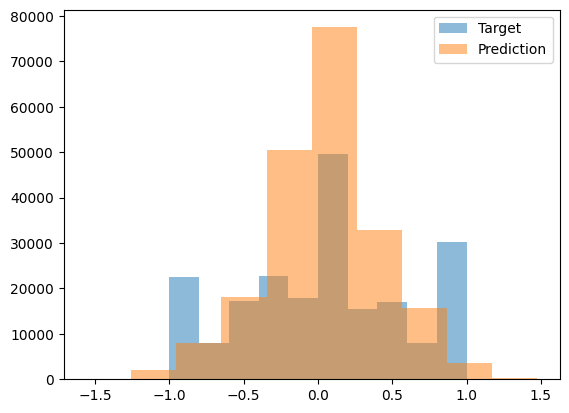

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Create feature types list for XGBoost
    feature_types = [
        "c" if col in categorical_cols else "q" 
        for col in numerical_cols + categorical_cols
    ]

    # Create XGBoost DMatrix for test data
    test_dmatrix = xgb.DMatrix(
        data=test_processed[numerical_cols + categorical_cols],
        feature_types=feature_types,
        enable_categorical=True
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_dmatrix)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [20]:
# Save all artifacts needed for prediction
xgboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'encoder': encoder,
    'scaler': scaler
}

with open(f'./xgboost_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(xgboost_predict, f)

***